<a href="https://colab.research.google.com/github/Maneekul/Intern/blob/main/Resnet34_Cars.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Car Make and Model Detection**
James Wang

README: https://people.ucsc.edu/~jwang402/car_det

PyTorch

Note: Run all cells in order in Google Colab for functionality.
Only tested on **Google Colab** with **GPU runtime**.

Requires NVIDIA CUDA Support

**Import all necessary packages:**

In [ ]:
import tarfile
import os
import csv
import time
import torch
import json
from random import randint
from pathlib import Path
from PIL import Image
import PIL.Image
from scipy.io import loadmat
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
import torchvision.models as models
from matplotlib.ticker import FormatStrFormatter
from google.colab.patches import cv2_imshow
import matplotlib.image as mpimg
from matplotlib.pyplot import imshow
from google.colab import drive
from IPython.display import Image
%matplotlib inline


**Download and extract files from Stanford University Repo**


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Path to the tar file in your Google Drive
tar_file_path = '/content/drive/MyDrive/cars_train.tgz'


# Path to the folder where you want to extract the contents
extract_folder_path = '/tmp/cars_train.tgz/'

# Create the extract folder if it doesn't already exist
os.makedirs(extract_folder_path, exist_ok=True)

# Extract the contents of the tar file to the extract folder
with tarfile.open(tar_file_path, 'r') as tar_ref:
    tar_ref.extractall(extract_folder_path)


In [ ]:
# Path to the tar file in your Google Drive
tar_file_path = '/content/drive/MyDrive/cars_test.tgz'

# Path to the folder where you want to extract the contents
extract_folder_path = '/tmp/cars_test.tgz/'

# Create the extract folder if it doesn't already exist
os.makedirs(extract_folder_path, exist_ok=True)

# Extract the contents of the tar file to the extract folder
with tarfile.open(tar_file_path, 'r') as tar_ref:
    tar_ref.extractall(extract_folder_path)

In [ ]:
# Path to the tar file in your Google Drive
tar_file_path = '/content/drive/MyDrive/car_devkit.tgz'

# Path to the folder where you want to extract the contents
extract_folder_path = '/tmp/car_devkit.tgz'

# Create the extract folder if it doesn't already exist
os.makedirs(extract_folder_path, exist_ok=True)

# Extract the contents of the tar file to the extract folder
with tarfile.open(tar_file_path, 'r') as tar_ref:
    tar_ref.extractall(extract_folder_path)

**Load Class Mapping**

In [ ]:
#Classes are assigned numerical value of 1-196, each
#mapping to a string. Data from cars_meta matlab file
#This applies to all data.
meta = loadmat('/tmp/car_devkit.tgz/devkit/cars_meta.mat')
meta.keys()
type(meta['class_names']),meta['class_names'].shape
[item.flat[0] for item in meta['class_names'][0][0]]
classes = [[row.flat[0] for row in line] for line in meta['class_names'][0]]
classDict = {}
classCount = 1
for c in classes:
    classDict.update({classCount:c[0]})
    classCount = classCount + 1
term = 0
for num, model in classDict.items():
    print('Class #', num,'Model String:', model)
    term = term + 1
    if term == 4:
        break
print('...')


Class # 1 Model String: AM General Hummer SUV 2000
Class # 2 Model String: Acura RL Sedan 2012
Class # 3 Model String: Acura TL Sedan 2012
Class # 4 Model String: Acura TL Type-S 2008
...


**Load labels**

In [ ]:
#LABELS FOR TRAINING DATA
#contains bbox, class, and filename
labelfile = loadmat('/tmp/car_devkit.tgz/devkit/cars_train_annos.mat')
labelfile.keys()
type(labelfile['annotations']),labelfile['annotations'].shape
type(labelfile['annotations'][0][0]),labelfile['annotations'][0][0].shape
labelfile['annotations'][0][0]['bbox_x1'], labelfile['annotations'][0][0]['fname']
[item.flat[0] for item in labelfile['annotations'][0][0]]
"""
The following variable 'trainLabels' contains a list of labels for
every test image the format of each element is as follows:
### bbox_x1, bbox_y1, bbox_x2, bbox_y2, class, filename
"""
trainLabels = [[row.flat[0] for row in line] for line in labelfile['annotations'][0]]
#Outputting the table for readibility with pandas
columns = ['boundingbox_x1', 'boundingbox_y1', 'boundingbox_x2', 'boundingbox_y2', 'class', 'fname']
view = pd.DataFrame(trainLabels, columns=columns)
view.head()


,boundingbox_x1,boundingbox_y1,boundingbox_x2,boundingbox_y2,class,fname
0,39,116,569,375,14,00001.jpg
1,36,116,868,587,3,00002.jpg
2,85,109,601,381,91,00003.jpg
3,621,393,1484,1096,134,00004.jpg
4,14,36,133,99,106,00005.jpg


In [ ]:
#LABELS FOR TESTING DATA
#Contains bbox and filename
lf = loadmat('/tmp/car_devkit.tgz/devkit/cars_test_annos.mat')
lf.keys()
type(lf['annotations']),lf['annotations'].shape
type(lf['annotations'][0][0]),lf['annotations'][0][0].shape
lf['annotations'][0][0]['bbox_x1'], lf['annotations'][0][0]['fname']
[item.flat[0] for item in lf['annotations'][0][0]]
"""
The following variable 'testLabels' contains a list of labels for
every test image the format of each element is as follows:
### bbox_x1, bbox_y1, bbox_x2, bbox_y2, filename
there is no class name in this set of labels
"""
testLabels = [[row.flat[0] for row in line] for line in lf['annotations'][0]]

#Test labels class and fname
with open('/content/drive/MyDrive/csv_label/model_class_boundedtest.csv') as csv_file:
    read = csv.reader(csv_file, delimiter=',')
    testDict = {}
    classCount = 1
    for row in read:
        testDict.update({row[0]:row[1]})
        classCount = classCount + 1
    print(testDict)
    print(len(testDict), 'processed')

{'00076.jpg': '1', '00457.jpg': '1', '00684.jpg': '1', '01117.jpg': '1', '01167.jpg': '1', '01199.jpg': '1', '01226.jpg': '1', '01461.jpg': '1', '01518.jpg': '1', '01538.jpg': '1', '01802.jpg': '1', '01887.jpg': '1', '01918.jpg': '1', '01946.jpg': '1', '02017.jpg': '1', '02205.jpg': '1', '02217.jpg': '1', '02267.jpg': '1', '02547.jpg': '1', '02602.jpg': '1', '02665.jpg': '1', '02835.jpg': '1', '03073.jpg': '1', '03094.jpg': '1', '03193.jpg': '1', '03246.jpg': '1', '03585.jpg': '1', '03640.jpg': '1', '03876.jpg': '1', '03904.jpg': '1', '04088.jpg': '1', '04117.jpg': '1', '04768.jpg': '1', '05023.jpg': '1', '05275.jpg': '1', '05605.jpg': '1', '05888.jpg': '1', '06051.jpg': '1', '07258.jpg': '1', '07393.jpg': '1', '07530.jpg': '1', '07917.jpg': '1', '07948.jpg': '1', '08035.jpg': '1', '00128.jpg': '2', '00130.jpg': '2', '00386.jpg': '2', '00565.jpg': '2', '00711.jpg': '2', '01002.jpg': '2', '01035.jpg': '2', '01176.jpg': '2', '01326.jpg': '2', '01864.jpg': '2', '02011.jpg': '2', '02182.jp

In [ ]:
#What labels look like for Training vs Testing after processing
print("Train Labels")
print("...")
for i in range(len(trainLabels) - 4, len(trainLabels)):
    print(trainLabels[i])
print("\nTest Labels")
print("...")
for i in range(len(testLabels) - 4, len(testLabels)):
    print(testLabels[i])


Train Labels
...
[138, 150, 706, 523, 196, '08141.jpg']
[26, 246, 660, 449, 163, '08142.jpg']
[78, 526, 1489, 908, 112, '08143.jpg']
[20, 240, 862, 677, 17, '08144.jpg']

Test Labels
...
[23, 18, 640, 459, '08038.jpg']
[33, 27, 602, 252, '08039.jpg']
[33, 142, 521, 376, '08040.jpg']
[77, 73, 506, 380, '08041.jpg']


**Preprocess Images**

In [ ]:
"""
Preprocess Training Images
Gets all training images and crops by bounding box, saves to a new directory
The directory housing training image has subdirectories named by class name
with each corresponding image in the corresponding folder
Saves ~7% of images for validation
"""
print(len(trainLabels), "images to process.")
Path("/tmp/processedTrain").mkdir(parents=True, exist_ok=True)
Path("/tmp/processedValidation").mkdir(parents=True, exist_ok=True)
count = 1
for l in trainLabels:
    print('Processing image', count, 'of', len(trainLabels))
    #bbox
    x1 = l[0]
    y1 = l[1]
    x2 = l[2]
    y2 = l[3]
    class_num = l[4]
    filename = l[5]
    address = "/tmp/cars_train.tgz/cars_train/" + filename
    classAppend = classDict.get(class_num) + '/'
    if count < 7000:
        saveDir = "/tmp/processedTrain/" + classAppend
    else:
        saveDir = "/tmp/processedValidation/" + classAppend
    im = PIL.Image.open(address)
    region = im.crop((x1, y1, x2, y2))
    Path(saveDir).mkdir(parents=True, exist_ok=True)
    saveAddress = saveDir + filename
    region.save(saveAddress)
    print('Saved', saveAddress)
    count = count + 1
print("------------------------")
print("Training images preprocessing complete.")

Streaming output truncated to the last 5000 lines.
Processing image 5646 of 8144
Saved /tmp/processedTrain/Chevrolet HHR SS 2010/05646.jpg
Processing image 5647 of 8144
Saved /tmp/processedTrain/Audi TT RS Coupe 2012/05647.jpg
Processing image 5648 of 8144
Saved /tmp/processedTrain/Bentley Arnage Sedan 2009/05648.jpg
Processing image 5649 of 8144
Saved /tmp/processedTrain/Ford F-150 Regular Cab 2007/05649.jpg
Processing image 5650 of 8144
Saved /tmp/processedTrain/BMW 3 Series Sedan 2012/05650.jpg
Processing image 5651 of 8144
Saved /tmp/processedTrain/Fisker Karma Sedan 2012/05651.jpg
Processing image 5652 of 8144
Saved /tmp/processedTrain/MINI Cooper Roadster Convertible 2012/05652.jpg
Processing image 5653 of 8144
Saved /tmp/processedTrain/Dodge Dakota Crew Cab 2010/05653.jpg
Processing image 5654 of 8144
Saved /tmp/processedTrain/BMW 1 Series Coupe 2012/05654.jpg
Processing image 5655 of 8144
Saved /tmp/processedTrain/Ford Freestar Minivan 2007/05655.jpg
Processing image 5656 of 81

In [ ]:
"""
Preprocess Testing Images
Gets all training images and crops by bounding box, saves to a new directory
"""
print(len(testLabels), "images to process.")
Path("/tmp/processedTest").mkdir(parents=True, exist_ok=True)
Path("/tmp/boundedTest").mkdir(parents=True, exist_ok=True)
count = 1
for l in testLabels:
    print('Processing image', count, 'of', len(testLabels))
    x1 = l[0]
    y1 = l[1]
    x2 = l[2]
    y2 = l[3]
    filename = l[4]
    c_num = testDict.get(filename)
    classAppend = classDict.get(int(c_num)) + '/'
    address = "/tmp/cars_test.tgz/cars_test/" + filename
    saveDir = "/tmp/processedTest/" + classAppend
    im = PIL.Image.open(address)
    region = im.crop((x1, y1, x2, y2))
    Path(saveDir).mkdir(parents=True, exist_ok=True)
    saveAddress = saveDir + filename
    saveAddress2 = "/tmp/boundedTest/" + filename
    region.save(saveAddress2)
    print('Saved', saveAddress2)
    region.save(saveAddress)
    print('Saved', saveAddress)
    count = count + 1
print("------------------------")
print("Testing images preprocessing complete.")


Streaming output truncated to the last 5000 lines.
Processing image 6376 of 8041
Saved /tmp/boundedTest/06376.jpg
Saved /tmp/processedTest/Rolls-Royce Phantom Sedan 2012/06376.jpg
Processing image 6377 of 8041
Saved /tmp/boundedTest/06377.jpg
Saved /tmp/processedTest/Dodge Ram Pickup 3500 Quad Cab 2009/06377.jpg
Processing image 6378 of 8041
Saved /tmp/boundedTest/06378.jpg
Saved /tmp/processedTest/Dodge Caravan Minivan 1997/06378.jpg
Processing image 6379 of 8041
Saved /tmp/boundedTest/06379.jpg
Saved /tmp/processedTest/Audi S4 Sedan 2012/06379.jpg
Processing image 6380 of 8041
Saved /tmp/boundedTest/06380.jpg
Saved /tmp/processedTest/Nissan Leaf Hatchback 2012/06380.jpg
Processing image 6381 of 8041
Saved /tmp/boundedTest/06381.jpg
Saved /tmp/processedTest/Hyundai Genesis Sedan 2012/06381.jpg
Processing image 6382 of 8041
Saved /tmp/boundedTest/06382.jpg
Saved /tmp/processedTest/Bentley Continental Supersports Conv. Convertible 2012/06382.jpg
Processing image 6383 of 8041
Saved /tmp/

**Preprocessed Image Demo**

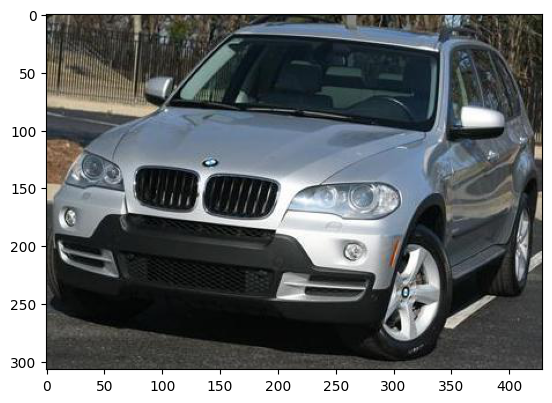

In [ ]:
#PROCESSED TEST IMAGE
im1_before = mpimg.imread("/tmp/boundedTest/08041.jpg")
imshow(im1_before)


**Transform and load**

In [ ]:
"""
Prepare dataset for loading into model. First transform images with flips and
rotations for robust model, then create loader with ImageFolder. Images will
be shuffled as well to ensure order doesn't matter.
"""
def getTrainLoad(directory):
    data = datasets.ImageFolder(directory,
                                transform = transforms.Compose([transforms.Resize((244,244)),
                                transforms.RandomRotation(30),
                                transforms.RandomHorizontalFlip(),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]))
    return torch.utils.data.DataLoader(data, batch_size=128, shuffle=True)

def getTestLoad(directory):
    data = datasets.ImageFolder(directory,
                                transform = transforms.Compose([transforms.Resize((244,244)),
                                transforms.CenterCrop(224),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]))
    return torch.utils.data.DataLoader(data, batch_size=32, shuffle=True)
trainLoad = getTrainLoad('/tmp/processedTrain')
validLoad = getTestLoad('/tmp/processedValidation')
testLoad = getTestLoad('/tmp/processedTest/')


**Transfer Learning - Resnet34 Implementation**

**Model Creation**


In [ ]:
model = models.resnet34(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 196)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
lrscheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=3, threshold = 0.9)
device = 'cuda'
model.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 203MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

**Train**

In [ ]:
start = time.time()
epochs = 10
iterations = 0
val = 35
model.to(device)
model.train()

def validation(model, validloader, criterion):
    valid_loss = 0
    accuracy = 0
    model.to(device)
    for i, (images, labels) in enumerate(validloader):
        images, labels = images.to(device), labels.to(device)
        output = model.forward(images)
        valid_loss = valid_loss + criterion(output, labels).item()
        ps = torch.exp(output)
        equality = (labels.data == ps.max(dim=1)[1])
        accuracy = accuracy + equality.type(torch.FloatTensor).mean()
    return valid_loss, accuracy

v_loss_hist = list()
tr_loss_hist = list()
v_acc_hist = list()

for e in range(epochs):
    running_loss = 0
    for i, (inputs, labels) in enumerate(trainLoad):
        iterations += 1
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model.forward(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        #validation
        if iterations % val == 0:
            model.eval()
            with torch.no_grad():
                valid_loss, accuracy = validation(model, validLoad, criterion)
            if (e + 1) > len(v_loss_hist):
                v_loss_hist.append(round(valid_loss/len(validLoad),3))
                tr_loss_hist.append(round(running_loss/val,3))
                v_acc_hist.append(round(float(accuracy/len(validLoad)),3))
            print(f"Epoch #  {e+1}, \
            Valid Loss: {round(valid_loss/len(validLoad),5)}, \
            Training Loss: {round(running_loss/val,5)}, \
            Valid Accuracy: {round(float(accuracy/len(validLoad)),5)}")
            model.train()
            lrscheduler.step(accuracy * 100)
end = time.time()
print("Training Complete.")
print("Training time in seconds:", end - start)

Epoch #  1,             Valid Loss: 5.42033,             Training Loss: 5.20361,             Valid Accuracy: 0.01302
Epoch #  2,             Valid Loss: 5.62677,             Training Loss: 1.623,             Valid Accuracy: 0.01934
Epoch #  2,             Valid Loss: 6.18861,             Training Loss: 4.78548,             Valid Accuracy: 0.03038
Epoch #  3,             Valid Loss: 6.65867,             Training Loss: 1.82518,             Valid Accuracy: 0.05219
Epoch #  4,             Valid Loss: 7.23097,             Training Loss: 0.3729,             Valid Accuracy: 0.04997
Epoch #  4,             Valid Loss: 7.53219,             Training Loss: 1.48152,             Valid Accuracy: 0.05927
Epoch #  5,             Valid Loss: 8.13339,             Training Loss: 0.51911,             Valid Accuracy: 0.06993
Epoch #  6,             Valid Loss: 8.33967,             Training Loss: 0.06773,             Valid Accuracy: 0.06101
Epoch #  6,             Valid Loss: 8.61777,             Training L

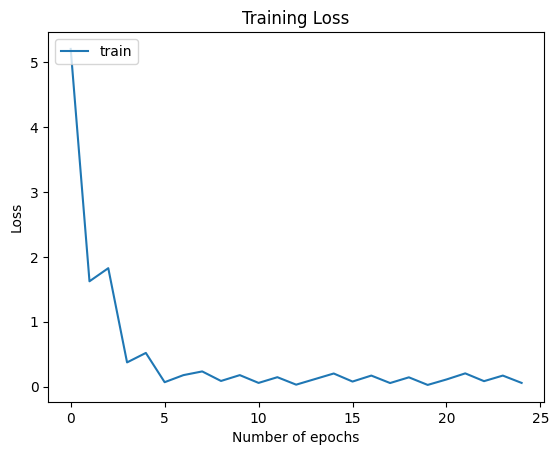

In [ ]:
plt.plot(tr_loss_hist)
plt.title('Training Loss')
plt.ylabel('Loss')
plt.xlabel('Number of epochs')
plt.legend(['train'], loc='upper left')
plt.show()


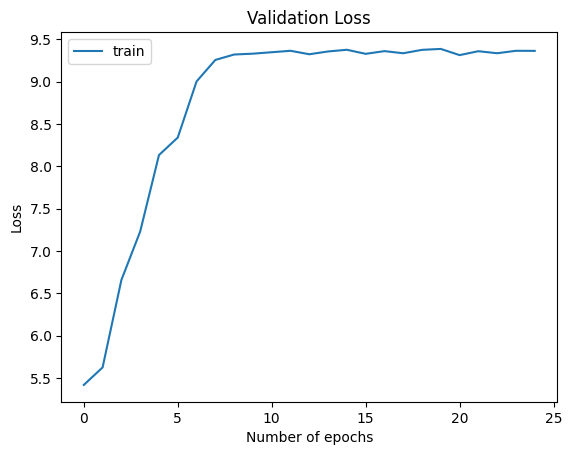

In [ ]:
plt.plot(v_loss_hist)
plt.title('Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Number of epochs')
plt.legend(['train'], loc='upper left')
plt.show()


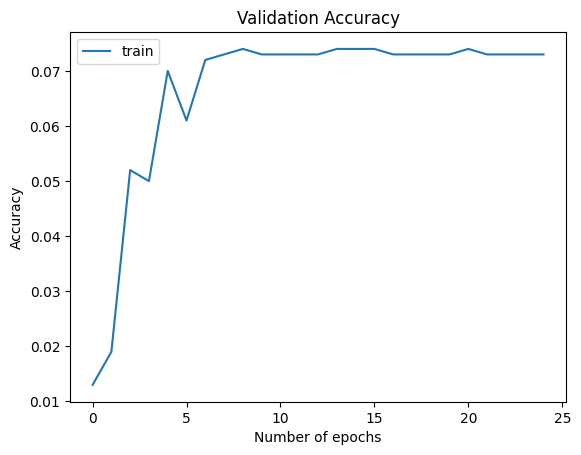

In [ ]:
plt.plot(v_acc_hist)
plt.title('Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Number of epochs')
plt.legend(['train'], loc='upper left')
plt.show()


In [ ]:
model.to(device)
"""
Tests model accuracy with test images
"""
start = time.time()
total = 0
correct = 0
acc_hist = list()
tot_hist = list()
with torch.no_grad():
    for data in testLoad:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, guess = torch.max(outputs.data, 1)
        total = total + labels.size(0) #total num of images
        correct = correct + (guess == labels).sum().item() #number correct
        acc_hist.append(correct)
        tot_hist.append(total)
end = time.time()
print("Total images tested in model:", len(testLabels))
print("Total accurate predictions:", correct)
print(f"Accuracy of model w/ full test dataset fed: {round(100 * correct / total,8)}%")
print("Testing time in seconds:", end - start)


Total images tested in model: 8041
Total accurate predictions: 1858
Accuracy of model w/ full test dataset fed: 23.10657878%
Testing time in seconds: 73.5491087436676


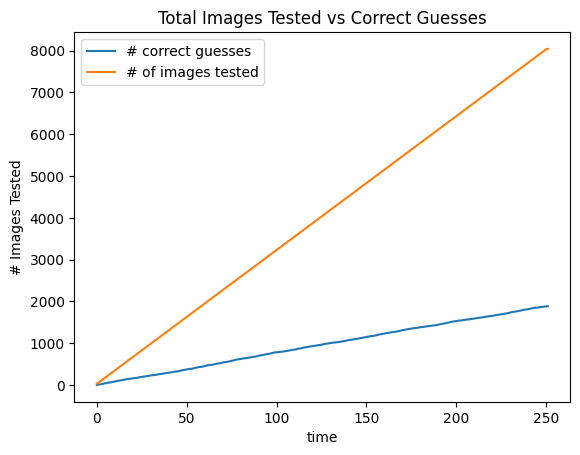

In [ ]:
plt.plot(acc_hist)
plt.plot(tot_hist)
plt.title('Total Images Tested vs Correct Guesses')
plt.ylabel('# Images Tested')
plt.xlabel('time')
plt.legend(['# correct guesses', '# of images tested'], loc='upper left')
plt.show()


**Make a CPU copy of the Model for testing**

In [ ]:
#make a copy of the model to change from gpu to cpu.
import copy
model_copy = copy.deepcopy(model)
model_copy.to('cpu')

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
def find_classes(dir):
    classes = os.listdir(dir)
    classes.sort()
    class_to_idx = {classes[i]: i for i in range(len(classes))}
    return classes, class_to_idx
classes, idx = find_classes("/tmp/processedTest/")

def predict(image, model, topk=5):
    #open image and change to np form//cpu consideration
    pil_in = PIL.Image.open(image).convert('RGB')
    transform = transforms.Compose([transforms.Resize((244,244)),
                                    transforms.CenterCrop(224),
                                    transforms.ToTensor(),
                                    transforms.Normalize([0.485, 0.456, 0.406],
                                                         [0.229, 0.224, 0.225])])
    pilTrans = transform(pil_in)
    img = np.array(pilTrans)
    img_tensor = torch.from_numpy(img).type(torch.FloatTensor) #np to tensor
    dimen = img_tensor.unsqueeze_(0)
    model.eval()
    with torch.no_grad():
        output = model.forward(dimen)
    probs_top = output.topk(topk)[0]
    top_prediction = output.topk(topk)[1]
    p = np.array(top_prediction)[0]
    o_guesses = np.array(top_prediction)[0]
    return p, o_guesses

**Randomly pick a test image to predict**

Randomly chosen file to classify: /tmp/boundedTest/05285.jpg
Seconds elapsed for prediction: 0.2742469310760498
*******************************
FIRST GUESS:  Jeep Grand Cherokee SUV 2012
*******************************
Might also be: Jeep Compass SUV 2012
Might also be: Ford Edge SUV 2012
Might also be: BMW X3 SUV 2012
Might also be: Jeep Liberty SUV 2012 



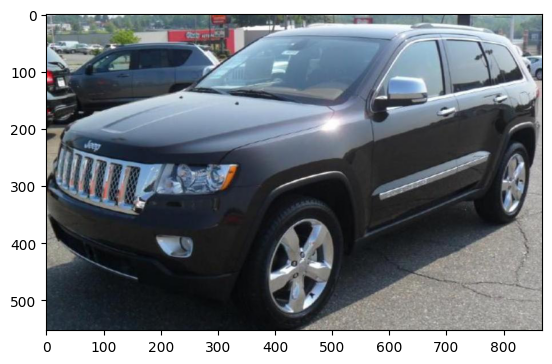

In [ ]:
random_test_image = str(str(randint(1, len(testLabels))).zfill(5)) + '.jpg'
image_to_classify = "/tmp/boundedTest/" + random_test_image
device = ('cpu')
start = time.time()
tp, ps = predict(image_to_classify, model_copy, topk=5)
print("Randomly chosen file to classify:",image_to_classify)
end = time.time()
print("Seconds elapsed for prediction:", end - start)
print("*******************************")
print("FIRST GUESS: ",classes[ps[0]])
print("*******************************")
print("Might also be:", classes[ps[1]])
print("Might also be:", classes[ps[2]])
print("Might also be:", classes[ps[3]])
print("Might also be:", classes[ps[4]], "\n")
gimg = mpimg.imread(image_to_classify)
imshow(gimg)


In [ ]:
data_test_cars = pd.read_csv('/content/drive/MyDrive/csv_label/model_class_boundedtest.csv', header=None, names=['filename', 'class' ])
list_array_test = data_test_cars.values.tolist()
print(list_array_test)
print(list_array_test[8040][0])
print(list_array_test[0][1])
print(type(list_array_test[8040][0]))


data_test_cars_year_model = pd.read_csv('/content/drive/MyDrive/csv_label/real_label_boundedtest.csv', header=None, names=['filename'])
class_test_year_model = data_test_cars_year_model.values.tolist()
print(class_test_year_model)





[['00076.jpg', 1], ['00457.jpg', 1], ['00684.jpg', 1], ['01117.jpg', 1], ['01167.jpg', 1], ['01199.jpg', 1], ['01226.jpg', 1], ['01461.jpg', 1], ['01518.jpg', 1], ['01538.jpg', 1], ['01802.jpg', 1], ['01887.jpg', 1], ['01918.jpg', 1], ['01946.jpg', 1], ['02017.jpg', 1], ['02205.jpg', 1], ['02217.jpg', 1], ['02267.jpg', 1], ['02547.jpg', 1], ['02602.jpg', 1], ['02665.jpg', 1], ['02835.jpg', 1], ['03073.jpg', 1], ['03094.jpg', 1], ['03193.jpg', 1], ['03246.jpg', 1], ['03585.jpg', 1], ['03640.jpg', 1], ['03876.jpg', 1], ['03904.jpg', 1], ['04088.jpg', 1], ['04117.jpg', 1], ['04768.jpg', 1], ['05023.jpg', 1], ['05275.jpg', 1], ['05605.jpg', 1], ['05888.jpg', 1], ['06051.jpg', 1], ['07258.jpg', 1], ['07393.jpg', 1], ['07530.jpg', 1], ['07917.jpg', 1], ['07948.jpg', 1], ['08035.jpg', 1], ['00128.jpg', 2], ['00130.jpg', 2], ['00386.jpg', 2], ['00565.jpg', 2], ['00711.jpg', 2], ['01002.jpg', 2], ['01035.jpg', 2], ['01176.jpg', 2], ['01326.jpg', 2], ['01864.jpg', 2], ['02011.jpg', 2], ['02182.j

In [ ]:
import re
path = "/tmp/boundedTest/"
files = os.listdir(path)
#print(files)
#print(len(files))
top1_count = 0
top2_count = 0
top3_count = 0
top4_count = 0
top5_count = 0
AllWrong = 0

for file in files:
    if file.endswith('.jpg'):
        img_path = os.path.join(path, file)
        #print(img_path)


        picture_label = file.split('.')[0]  # Get the true label from the filename
        picture_label = picture_label  + '.jpg'  # ex. 05630.jpg
        #print(picture_label)
        #print(type(picture_label))

    for i in range(len(list_array_test)):
      if list_array_test[i][0] == picture_label:
        x = list_array_test[i][1]
        x = int(x)
        print('class number =',x)

Streaming output truncated to the last 5000 lines.
class number = 164
class number = 55
class number = 77
class number = 180
class number = 151
class number = 2
class number = 8
class number = 149
class number = 176
class number = 184
class number = 104
class number = 169
class number = 188
class number = 47
class number = 87
class number = 137
class number = 154
class number = 164
class number = 29
class number = 130
class number = 120
class number = 72
class number = 195
class number = 51
class number = 125
class number = 4
class number = 149
class number = 54
class number = 19
class number = 84
class number = 46
class number = 51
class number = 133
class number = 43
class number = 67
class number = 188
class number = 85
class number = 88
class number = 90
class number = 67
class number = 174
class number = 72
class number = 40
class number = 188
class number = 147
class number = 195
class number = 194
class number = 42
class number = 118
class number = 37
class number = 69
class num

In [ ]:
path = "/tmp/boundedTest/"
files = os.listdir(path)
#print(files)
#print(len(files))
top1_count = 0
top2_count = 0
top3_count = 0
top4_count = 0
top5_count = 0
AllWrong = 0

for file in files:
    if file.endswith('.jpg'):
        img_path = os.path.join(path, file)
        #print(img_path)


        picture_label = file.split('.')[0]  # Get the true label from the filename
        picture_label = picture_label  + '.jpg'  # ex. 05630.jpg
        #print(picture_label)
        #print(type(picture_label))

    for i in range(len(list_array_test)):
      if list_array_test[i][0] == picture_label:
        x = list_array_test[i][1]
        x = int(float(x))
        print('class number =',x)
        true_label = classes[x-1]
        print('true_label = ',true_label)


       # for i_list in range(len(list_array_test)):
       #     i_list = 0
       #     if list_array_test[i][0] == picture_label:
       #       print(picture_label)
       #       x = list_array_test[i][1]
       #       x = int(x)
       #       print('class number =',x)
       #       true_label = classes[x-1]
       #       print('true_label = ',true_label)


        #print('class number =',x)
        #print('true_label = ',true_label)
        device = ('cuda')
        tp, ps = predict(img_path, model_copy, topk=5)
        realPS = ps+1
        print('realPS = ',realPS)  #realPS[0 1 2 3 4]


        print('classes[ps[0]][0] = ',classes[ps[0]])
        print('classes[ps[1]][0] = ',classes[ps[1]])
        print('classes[ps[2]][0] = ',classes[ps[2]])
        print('classes[ps[3]][0] = ',classes[ps[3]])
        print('classes[ps[4]][0] = ',classes[ps[4]])

        if classes[ps[0]] == true_label:
            top1_count += 1
            print('11111111111111111111111111111111111111111111111111111111111111111111111111111')
        elif classes[ps[1]] == true_label:
            top2_count += 1
            print('22222222222222222222222222222222222222222222222222222222222222222222222222222')
        elif classes[ps[2]] == true_label:
            top3_count += 1
            print('33333333333333333333333333333333333333333333333333333333333333333333333333333')
        elif classes[ps[3]] == true_label:
            top4_count += 1
            print('444444444444444444444444444444444444444444444444444444444444444444444444444444')
        elif classes[ps[4]] == true_label:
            top5_count += 1
            print('555555555555555555555555555555555555555555555555555555555555555555555555555555')
        else:
            AllWrong += 1
            print("ALL SQUENCE WRONGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGG")

print("Top 1 accuracy: ", top1_count/len(files))
print("Top 2 accuracy: ", top2_count/len(files))
print("Top 3 accuracy: ", top3_count/len(files))
print("Top 4 accuracy: ", top4_count/len(files))
print("Top 5 accuracy: ", top5_count/len(files))
print("  ALL WRONG   : ", AllWrong/len(files))

Streaming output truncated to the last 5000 lines.
true_label =  Volkswagen Golf Hatchback 2012
realPS =  [192 172  82  66 133]
classes[ps[0]][0] =  Volkswagen Golf Hatchback 2012
classes[ps[1]][0] =  Plymouth Neon Coupe 1999
classes[ps[2]][0] =  Daewoo Nubira Wagon 2002
classes[ps[3]][0] =  Chevrolet Monte Carlo Coupe 2007
classes[ps[4]][0] =  Hyundai Elantra Touring Hatchback 2012
11111111111111111111111111111111111111111111111111111111111111111111111111111
class number = 160
true_label =  McLaren MP4-12C Coupe 2012
realPS =  [151 160 150  11 196]
classes[ps[0]][0] =  Lamborghini Diablo Coupe 2001
classes[ps[1]][0] =  McLaren MP4-12C Coupe 2012
classes[ps[2]][0] =  Lamborghini Aventador Coupe 2012
classes[ps[3]][0] =  Aston Martin Virage Coupe 2012
classes[ps[4]][0] =  smart fortwo Convertible 2012
22222222222222222222222222222222222222222222222222222222222222222222222222222
class number = 155
true_label =  Land Rover Range Rover SUV 2012
realPS =  [155 145  13 167 106]
classes[ps[0]